In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from mtcnn import mtcnn
import cv2

In [2]:
model_file = 'model/facenet_keras.h5'
FRmodel = tf.keras.models.load_model(model_file)
# summarize input and output shape
print(FRmodel.inputs)
print(FRmodel.outputs)

[<tf.Tensor 'input_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(?, 128) dtype=float32>]


In [3]:
# Should be 22808144
print("Total Params:", FRmodel.count_params())

Total Params: 22808144


In [5]:
# FRmodel.load_weights("model/facenet_keras_weights.h5")

In [2]:
# Imports for face processing
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray

In [14]:
#improts for face detection
from cv2 import imread
from cv2 import CascadeClassifier
classifier = CascadeClassifier('haarcascade_frontalface_default.xml')

In [5]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
#     image = Image.open(filename)
    image = cv2.imread(filename)
    #print("file downloaded... \r")
    # convert to RGB, if needed
#     image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    pixels = pixels[...,::-1]
    pixels = cv2.resize(pixels, required_size)
    # create the detector, using default weights
    
        #-----------------------
    # Skip this because hopefully it's already done ( by lfw )!
    detector = mtcnn.MTCNN()
#     # detect faces in the image
    results = detector.detect_faces(pixels)
#     # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
#     # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
#     # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    #-----------------------
    face = cv2.resize(face, required_size)
#     image = Image.fromarray(face)
#     image = image.resize(required_size)
#     image = image[...,::-1]
#     image = cv2.resize(image, required_size)

    face_array = asarray(face)
    #print("file downloaded... processed")
    return face_array

In [65]:
# load images and extract faces for all images in a directory
def load_faces_from_folder(directory):
    faces = list()
    for filename in listdir(directory):
        print("loading file ", filename)
        path = directory + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def laod_face_from_folder_fast(directory, required_size = (160, 160)):
    aligned_faces = list()
    count = 0
    for filename in listdir(directory):
#         print("loading file ", filename)
        path = directory + filename
    #     face = extract_face(path)

        image = cv2.imread(path)
        bboxes = classifier.detectMultiScale(image)
        # print bounding box for each detected face
        if len(bboxes) == 0:
#             print('oops')
            continue
        
        # extract
        x, y, width, height = bboxes[0]
        x2, y2 = x + width, y + height
        aligned_face = image[y:y2, x:x2]
        
        # resize pixels to the model size
        aligned_face = cv2.resize(aligned_face, required_size)
        aligned_face = cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB)
        aligned_faces.append(aligned_face)
        
        count = count + 1
        if count % 500 == 0:
            print('loaded', count, 'examples')
#         if count > 200:
#             print("done!")
#             break
    return aligned_faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the subdirectory
        faces = laod_face_from_folder_fast(path, required_size = (80, 80))
        labels = [subdir for _ in range(len(faces))]
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [66]:
# get the face embedding for one face
def img_to_embedding(face_pixels, FRmodel):
    # print('start')
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    # print('starting prediction')
    yhat = FRmodel.predict(samples)
    # print('done with prediction')
    return yhat[0]

def face_list_to_embedding_list(face_pixels_list, model):
    return [img_to_embedding(face, model) for face in face_pixels_list]

# load a dataset that contains one subdir for each class that in turn contains images
def create_embeddings_from_dataset(directory, model):
    pictures = list()
    embeddings = list()
    names = list()
    # enumerate folders, on per class
    totalDownloaded = 0
    for subdir in listdir(directory):
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces_from_folder(path)
        emb_list = face_list_to_embedding_list(faces, model)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        # store
        pictures.extend(faces)
        embeddings.extend(emb_list)
        names.extend(labels)
        
        totalDownloaded = totalDownloaded + 1
        if (totalDownloaded > 1000):
            break
        
    return asarray(pictures), asarray(embeddings), asarray(names)

# Shows a picture of a face from the pixel values
def show_face_from_pixels(face_pixels):
    pyplot.imshow(face_pixels)

In [67]:
# dataset = 'lfw-deepfunneled/'
dataset = 'celeba/'
# pictures, embeddings, names = create_embeddings_from_dataset(dataset, FRmodel)
pictures, names = load_dataset(dataset)

loaded 500 examples
loaded 1000 examples
loaded 1500 examples
loaded 2000 examples
loaded 2500 examples
loaded 3000 examples
loaded 3500 examples
loaded 4000 examples
loaded 4500 examples
loaded 5000 examples
loaded 5500 examples
loaded 6000 examples
loaded 6500 examples
loaded 7000 examples
loaded 7500 examples
loaded 8000 examples
loaded 8500 examples
loaded 9000 examples
loaded 9500 examples
loaded 10000 examples
loaded 10500 examples
loaded 11000 examples
loaded 11500 examples
loaded 12000 examples
loaded 12500 examples
loaded 13000 examples
loaded 13500 examples
loaded 14000 examples
loaded 14500 examples
loaded 15000 examples
loaded 15500 examples
loaded 16000 examples
loaded 16500 examples
loaded 17000 examples
loaded 17500 examples
loaded 18000 examples
loaded 18500 examples
loaded 19000 examples
loaded 19500 examples
loaded 20000 examples
loaded 20500 examples
loaded 21000 examples
loaded 21500 examples
loaded 22000 examples
loaded 22500 examples
loaded 23000 examples
loaded 2

loaded 183500 examples
loaded 184000 examples
loaded 184500 examples
loaded 185000 examples
loaded 185500 examples
loaded 186000 examples
loaded 186500 examples
loaded 187000 examples
loaded 187500 examples
loaded 188000 examples
loaded 188500 examples
loaded 189000 examples
loaded 189500 examples
loaded 190000 examples
loaded 190500 examples
loaded 191000 examples
loaded 191500 examples
loaded 192000 examples
loaded 192500 examples
loaded 193000 examples
loaded 193500 examples
loaded 194000 examples
loaded 194500 examples
loaded 195000 examples
>loaded 195354 examples for class: img_align_celeba


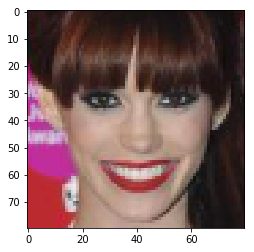

In [68]:
# img1 = cv2.imread('lfw-deepfunneled/Doug_Moe/Doug_Moe_0001.jpg')
# img = img1[...,::-1]
# img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
# img.shape
pyplot.imshow(pictures[20])

In [36]:
# embeddings = FRmodel.predict(pictures)

In [69]:
randomize = np.arange(len(pictures))
np.random.shuffle(randomize)
pictures2 = pictures[randomize]
# embeddings2 = embeddings[randomize]
names2 = names[randomize]

In [39]:
train_size = 12000
train_pics = pictures2[:train_size]
train_embs = embeddings2[:train_size]
train_name = names2[:train_size]

test_size = int((int(len(pictures2))-train_size)/2)
test_pics = pictures2[train_size:train_size+test_size]
test_embs = embeddings2[train_size:train_size+test_size]
test_name = names2[train_size:train_size+test_size]

dev_pics = pictures2[train_size+test_size:]
dev_embs = embeddings2[train_size+test_size:]
dev_name = names2[train_size+test_size:]

# sanity check
print('train set size: ', len(train_pics))
print('test set size: ', len(test_pics))
print('test set size: ', len(dev_pics))

train set size:  1800
test set size:  241
test set size:  241


In [40]:
savez_compressed('train-data3.npz', train_pics, train_embs, train_name)
savez_compressed('dev-data3.npz', test_pics, test_embs, test_name)
savez_compressed('test-data3.npz', dev_pics, dev_embs, dev_name)

In [70]:
savez_compressed('celeba_aligned.npz', pictures2, names2)

In [13]:
faces11 = load_faces_from_folder('lfw-deepfunneled/George_HW_Bush/')

loading file  George_HW_Bush_0004.jpg
loading file  George_HW_Bush_0006.jpg
loading file  George_HW_Bush_0012.jpg
loading file  George_HW_Bush_0009.jpg
loading file  George_HW_Bush_0005.jpg
loading file  George_HW_Bush_0007.jpg
loading file  George_HW_Bush_0001.jpg
loading file  George_HW_Bush_0002.jpg
loading file  George_HW_Bush_0013.jpg
loading file  George_HW_Bush_0003.jpg
loading file  George_HW_Bush_0011.jpg
loading file  George_HW_Bush_0008.jpg
loading file  George_HW_Bush_0010.jpg
